In [1]:
import sys
import os
import pandas as pd
import copy

# Add the parent directory of the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))

In [2]:
from transformers import AutoTokenizer
from benchmark_workload_gen import ToolBenchDataLoader, LoadDistribution
from sglang.srt.managers.router.radix_cache import RadixCache

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = ToolBenchDataLoader('G1_workload_updated_input_output_lengths_4096_cropped_to_50.json', num_workloads, num_requests, tokenizer, LoadDistribution.EVEN)

In [3]:
workload = dataloader.generate_workload(k=1.1)

4000


In [4]:
import re
def get_tool(workload_item):
    text = workload_item["text"]
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
get_tool(workload[0]), get_tool(workload[1])

('surebets', 'manga_scrapper')

In [132]:
import heapq
import time
from collections import defaultdict
from dataclasses import dataclass
from typing import Tuple

import torch

class TreeNode:
    def __init__(self):
        self.children = defaultdict(TreeNode)
        self.parent = None
        self.value = None
        self.ref_counter = 0
        self.last_access_time = time.time()
        self.gpu_selections = set()

    @property
    def num_tokens(self):
        return len(self.value)
        
    def __lt__(self, other):
        return self.last_access_time < other.last_access_time
    
    def __eq__(self, other):
        if isinstance(other, TreeNode):
            return self.value == other.value
        return False

    def __hash__(self):
        return hash(tuple(self.value))

def match(key, seq):
    i = 0
    for k, w in zip(key, seq):
        if k != w:
            break
        i += 1
    return i


class RadixCache:
    def __init__(self, disable=False):
        self.reset()
        self.disable = disable

    ##### Public API #####

    def reset(self):
        self.root_node = TreeNode()
        self.root_node.value = []
        self.root_node.ref_counter = 1
        self.evictable_size_ = 0

    def match_prefix_get_gpu_selection(self, key):
        if self.disable:
            return [], self.root_node

        value = []
        current_gpu_selection = self.root_node.gpu_selections
        print("current_gpu_selection", current_gpu_selection)
        current_gpu_selection = self._match_prefix_helper_gpu_selection(self.root_node, key, value, current_gpu_selection)
        return current_gpu_selection

    def _match_prefix_helper_gpu_selection(self, node, key, value, current_gpu_selection):
        node.last_access_time = time.time()
        child: TreeNode
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                if child.gpu_selections:
                    current_gpu_selection = child.gpu_selections
                    print("current_gpu_selection", current_gpu_selection)
                if prefix_len < len(c_key):
                    new_node = self._split_node(c_key, child, prefix_len)
                    value.append(new_node.value)
                    # last_node[0] = new_node
                else:
                    value.append(child.value)
                    # last_node[0] = child
                    self._match_prefix_helper_gpu_selection(child, key[prefix_len:], value, current_gpu_selection)
                break
        return current_gpu_selection

    def match_prefix(self, key):
        if self.disable:
            return [], self.root_node

        value = []
        last_node = [self.root_node]
        self._match_prefix_helper(self.root_node, key, value, last_node)
        if value:
            if isinstance(value[0], torch.Tensor):
                value = torch.concat(value)
            else:
                concatenated_value = []
                for v in value:
                    concatenated_value.extend(v)  # Assuming each element in value is a list itself
                value = concatenated_value
        return value, last_node[0]

    def match_prefix_return_str(self, key):
        return "".join(self.match_prefix(key)[0])

    def insert(self, key, value=None):
        if self.disable:
            return len(key)

        if value is None:
            value = [x for x in key]
        return self._insert_helper(self.root_node, key, value)

    def pretty_print(self):
        self._print_helper(self.root_node, 0)
        print(f"#tokens: {self.total_size()}")

    def total_size(self):
        return self._total_size_helper(self.root_node)

    def evict(self, num_tokens, evict_callback):
        if self.disable:
            raise RuntimeError()

        leaves = self._collect_leaves()
        heapq.heapify(leaves)

        num_evicted = 0
        while num_evicted < num_tokens and len(leaves):
            x = heapq.heappop(leaves)

            if x == self.root_node:
                break
            if x.ref_counter > 0:
                continue

            num_evicted += evict_callback(x.value)
            self._delete_leaf(x)

            if len(x.parent.children) == 0:
                heapq.heappush(leaves, x.parent)

    def inc_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 0:
                self.evictable_size_ -= len(node.value)
                delta -= len(node.value)
            node.ref_counter += 1
            node = node.parent
        return delta

    def dec_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 1:
                self.evictable_size_ += len(node.value)
                delta += len(node.value)
            node.ref_counter -= 1
            node = node.parent
        return delta

    def evictable_size(self):
        return self.evictable_size_

    ##### Internal Helper Functions #####
    def _match_prefix_helper(self, node, key, value, last_node):
        node.last_access_time = time.time()
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                if prefix_len < len(c_key):
                    new_node = self._split_node(c_key, child, prefix_len)
                    value.append(new_node.value)
                    last_node[0] = new_node
                else:
                    value.append(child.value)
                    last_node[0] = child
                    self._match_prefix_helper(child, key[prefix_len:], value, last_node)
                break

    def _split_node(self, key, child, split_len):
        # new_node -> child
        new_node = TreeNode()
        new_node.gpu_selections = copy.deepcopy(child.gpu_selections)
        new_node.children = {key[split_len:]: child}
        new_node.parent = child.parent
        new_node.ref_counter = child.ref_counter
        new_node.value = child.value[:split_len]
        child.parent = new_node
        child.value = child.value[split_len:]
        new_node.parent.children[key[:split_len]] = new_node
        del new_node.parent.children[key]
        return new_node

    def _insert_helper(self, node, key, value):
        node.last_access_time = time.time()
        node.ref_counter += 1
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)

            if prefix_len == len(c_key):
                if prefix_len == len(key):
                    child.ref_counter += 1
                    return prefix_len
                else:
                    key = key[prefix_len:]
                    value = value[prefix_len:]
                    return prefix_len + self._insert_helper(child, key, value)

            if prefix_len:
                new_node = self._split_node(c_key, child, prefix_len)
                return prefix_len + self._insert_helper(
                    new_node, key[prefix_len:], value[prefix_len:]
                )

        if len(key):
            new_node = TreeNode()
            new_node.parent = node
            new_node.value = value
            new_node.ref_counter = 1
            node.children[key] = new_node
            self.evictable_size_ += len(value)
        return 0

    def _print_helper(self, node, indent, depth=0):
        if depth == 5:
            return
        for key, child in node.children.items():
            print(" " * indent, len(key), key[:10], f"r={child.ref_counter}")
            self._print_helper(child, indent=indent + 2, depth=depth + 1)
        

    def _delete_leaf(self, node):
        for k, v in node.parent.children.items():
            if v == node:
                break
        del node.parent.children[k]
        self.evictable_size_ -= len(k)

    def _total_size_helper(self, node):
        x = len(node.value)
        for child in node.children.values():
            x += self._total_size_helper(child)
        return x

    def _collect_leaves(self):
        ret_list = []

        def dfs_(cur_node):
            if len(cur_node.children) == 0:
                ret_list.append(cur_node)

            for x in cur_node.children.values():
                dfs_(x)

        dfs_(self.root_node)
        return ret_list

    

if __name__ == "__main__":
    tree = RadixCache(disable=False)

    tree.insert("Hello")
    tree.insert("Hello There")
    tree.insert("Hello_L.A.!")
    # tree.insert("Hello_world! Happy")
    # tree.insert("I love you!")
    tree.pretty_print()

    print(tree.match_prefix_return_str("Hello T"))

    # def evict_callback(x):
    #    print("evict", x)
    #    return len(x)

    # tree.evict(5, evict_callback)
    # tree.evict(10, evict_callback)
    # tree.pretty_print()


 5 Hello r=3
   6  There r=1
   6 _L.A.! r=1
#tokens: 17
Hello T


In [11]:
cache = RadixCache()
import random
random.shuffle(workload)
for item in workload[:20]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
# for i in range(100):
#     cache.insert(tuple(workload[0]["input_ids"]["input_ids"]))
# for j in range(100):
#     cache.insert(tuple(workload[1]["input_ids"]["input_ids"]))
# cache.insert(tuple(tokenizer.encode("bdd_special_tokens=True")))
cache.pretty_print()


 358 (1, 2135, 28747, 995, 460, 12191, 28777, 6316, 28725, 368) r=20
   1985 (21573, 11178, 28730, 28728, 28750, 28747, 4556, 346, 9087, 304) r=1
   1001 (28710, 452, 28730, 3016, 28747, 661, 349, 10429, 26748, 5212) r=1
   1572 (12625, 16965, 28730, 28714, 4737, 28730, 14199, 28730, 3016, 28747) r=1
   1379 (14040, 1575, 28747, 19417, 298, 813, 317, 28733, 24008, 7086) r=1
   1353 (15041, 28730, 824, 6131, 28730, 28728, 28781, 28747, 851, 10429) r=1
   875 (6193, 5987, 28730, 1231, 4334, 28747, 390, 28715, 20404, 28715) r=1
   1134 (1374, 381, 28730, 3016, 28747, 851, 7086, 5723, 1871, 356) r=1
   672 (8692, 28730, 2888, 263, 28747, 415, 6711, 426, 4914, 263) r=1
   631 (28721, 6857, 28730, 14290, 28730, 262, 28730, 980, 2295, 28747) r=1
   533 (25652, 28740, 28747, 23969, 28740, 13, 13, 4947, 921, 578) r=1
   945 (2186, 28730, 1009, 28730, 1237, 28730, 1466, 28747, 2483, 272) r=1
   3095 (28728, 545, 28709, 28747, 550, 545, 28709, 7086, 13, 13) r=1
   1323 (22747, 28730, 2860, 28730,

In [12]:
import numpy as np
from itertools import permutations


total_tokens_available = [33077, 33077, 33077]
nodes = {0: 0, 1: 0, 2:0}

def cost_fn(nodes, total_tokens):
    # how close are the loads of the two nodes
    # how many tokens are being used
    total_load = sum(nodes)

    return {
        "total_load": total_load,
        "total_tokens": sum(total_tokens),
        "load_ratio": np.std(nodes),
        "token_ratio": np.std(total_tokens)
    }


In [119]:
import cvxpy as cp

class LPTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.num_gpus_param = cp.Parameter(nonneg=True, value=num_gpus)
        self.counter = 0
        self.constraints = []
        self.node_map = {}  # Maps PrefixTreeNode to LpNode

        self.time_per_token_fixed_cost = cp.Parameter(nonneg=True, value=4.59)
        self.time_per_token_variable_cost = cp.Parameter(nonneg=True, value=0.1)
        self.load_cost_per_token = cp.Parameter(nonneg=True, value=200)

        self.num_tokens_params = {}
        self.ref_count_params = {}
        self.depth_limit = 4

    def _traverse_tree(self, current_prefix_node, parent_lp_node=None, depth=0):
        if depth == self.depth_limit:
            return
        self.counter += 1
        current_lp_node = LpNode(self.counter, self.num_gpus)
        self.node_map[current_prefix_node] = current_lp_node

        self.constraints += [cp.sum(current_lp_node.variables) >= 1] # At least one GPU must be allocated for a prefix
        if parent_lp_node:
            # Add constraints based on the relationship between the current node and its parent
            # If the child takes a node, then the parent must also take a node
            for gpu in range(self.num_gpus):
                self.constraints.append(current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu])

        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(child_prefix_node, current_lp_node, depth=depth + 1)

    def solve(self, objective):
        # Create problem and solve
        problem = cp.Problem(objective, self.constraints)
        problem.solve(solver=cp.GUROBI)

    def add_parent_child_gpu_constraints(self):
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if not parent_prefix_node.children:  # Skip leaf nodes
                continue
            for gpu_index in range(self.num_gpus):
                # For each GPU, ensure that if the parent selects it, at least one child also selects it.
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    child_lp_node = self.node_map.get(child_prefix_node)
                    if child_lp_node:  # Check if the child node exists in the LP node mapping
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:  # If there are child nodes with GPU selections
                    # Add a constraint that the parent's selection of this GPU is less than or equal to the sum of the children's selections
                    # This means the parent can only select this GPU if at least one child also selects it
                    self.constraints.append(parent_lp_node.variables[gpu_index] <= cp.sum(children_gpu_selections))


    def traverse_and_optimize(self, prefix_tree_root, existing_cost={}):
        start_time = time.time()
        self.constraints = []
        self._traverse_tree(prefix_tree_root)
        self.add_parent_child_gpu_constraints()

        memory_cost_terms = []
        load_cost_params = []

        per_gpu_cost = [[] for _ in range(self.num_gpus)]

        for prefix_node, lp_node in self.node_map.items():

            num_tokens_param = self.num_tokens_params.get(prefix_node, cp.Parameter(nonneg=True))
            num_tokens_param.value = prefix_node.num_tokens # Update parameter value
            
            load_param = self.ref_count_params.get(prefix_node, cp.Parameter(nonneg=True))
            load_param.value = prefix_node.ref_counter  # Update parameter value
            # memory_cost_terms += [2 * gpu_var  * num_tokens_param * (
            #     num_tokens_param * self.time_per_token_variable_cost + self.time_per_token_fixed_cost
            #     ) 
            # Load cost param 
            for gpu_id, gpu_var in enumerate(lp_node.variables):
                gpu_var.value = existing_cost.get(prefix_node, {}).get(gpu_id, 0)
                cost = gpu_var * num_tokens_param - gpu_var * existing_cost.get(prefix_node, {}).get(gpu_id, 0) * num_tokens_param
                per_gpu_cost[gpu_id].append(cost)
                memory_cost_terms.append(cost)
            #     penalty = (1 - gpu_var) * self.load_cost_per_token * num_tokens_param * load_param
            #     load_cost_params.append(penalty)
        max_per_gpu_cost = cp.Variable(nonneg=True, name='per_gpu_cost_lim')
        for i in range(self.num_gpus):
            self.constraints.append(cp.sum(per_gpu_cost[i]) <= max_per_gpu_cost)

        self.load_var = cp.Variable(nonneg=True, name='load_obj')
        self.constraints.append(self.load_var == cp.sum(load_cost_params))

        self.memory_var = cp.Variable(nonneg=True, name='memory_obj')
        self.constraints.append(self.memory_var == cp.sum(memory_cost_terms))

        # Define your objective function here, for example:
        objective = cp.Minimize(cp.sum(load_cost_params) + cp.sum(memory_cost_terms) + max_per_gpu_cost)  # Adjust according to your specific problem
        print(f"Setup time: {time.time() - start_time}s")
        # Solve the problem
        self._solve(objective)

    def _solve(self, objective):
        start_time = time.time()
        problem = cp.Problem(objective, self.constraints)
        # problem.solve(solver=cp.GUROBI, verbose=True)
        env = gurobipy.Env()
        env.setParam('TimeLimit', .2) # in seconds
        env.setParam('MIPGap', 0.1)  # Accept solutions within 1% of the optimal
        env.setParam('Threads', 64)  # Use all available threads
        env.setParam('OutputFlag', 0)  # Disable output
        env.start()

        problem.solve(solver=cp.GUROBI, verbose=False, env=env)  
        print(f"Solving time: {time.time() - start_time}s")

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        for prefix_node, lp_node in self.node_map.items():
            for i, gpu_var in enumerate(lp_node.variables):
                if gpu_var.value >= 0.99:  # If GPU i is selected by this node
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu

    def pretty_print(self, prefix_node):
        self.pretty_print_helper(prefix_node)
        tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        # load memory breakding 
        print(f"Memory cost: {self.memory_var.value}")
        print(f"Load cost: {self.load_var.value}")
        # print(f"Per gpu cost {[var.value for var in self.per_gpu_cost]}")
        # print(f"Balance penalty: {self.balan_var.value}")
    

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            # Assuming each lp_node.variables[i].value gives whether GPU i is selected
            selected_gpus = [i for i, var in enumerate(lp_node.variables) if var.value >= 0.99]  # Adjust threshold as needed
            print(f"{indent}Node {lp_node.node_id} {tokenizer.decode(prefix_node.value)[:10].strip()}: GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def get_exisiting_cost(self):
        existing_cost = {}
        for prefix_node, lp_node in self.node_map.items():
            for gpu_id, var in enumerate(lp_node.variables):
                if prefix_node not in existing_cost:
                    existing_cost[prefix_node] = {}
                existing_cost[prefix_node][gpu_id] = int(var.value)
        return existing_cost

# Assuming a Node class with attributes 'children' and 'node_id'
class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [cp.Variable(name=f"node_{node_id}_gpu_{gpu}", boolean=True) for gpu in range(num_gpus)]

import random, time
import gurobipy

lp_tree_traversal = LPTreeTraversal(3)
lp_tree_traversal.depth_limit = 4
cache = RadixCache()
random.shuffle(workload)
# for item in workload[:20]:
#     cache.insert(tuple(item["input_ids"]["input_ids"]))

# start_time = time.time()
# lp_tree_traversal.traverse_and_optimize(cache.root_node)
# lp_tree_traversal.pretty_print(cache.root_node)

# print("Time taken", time.time() - start_time)

for item in workload[:20]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
times = []

start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 20})
print("Time taken", time.time() - start_time)

for item in workload[20:40]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 40})

print("Time taken", time.time() - start_time)

for item in workload[40:100]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 60})
print("Time taken", time.time() - start_time)


for item in workload[100:200]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 100})
print("Time taken", time.time() - start_time)

start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 100})
print("Time taken", time.time() - start_time)

start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 100})
print("Time taken", time.time() - start_time)

start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 100})
print("Time taken", time.time() - start_time)

for item in workload[200:]:
    cache.insert(tuple(item["input_ids"]["input_ids"]))
start_time = time.time()
lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": 3800})
print("Time taken", time.time() - start_time)
# for item in workload[100:]:
#     cache.insert(tuple(item["input_ids"]["input_ids"]))
# start_time = time.time()
# lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
# print("Time taken", time.time() - start_time)
# lp_tree_traversal.pretty_print(cache.root_node)

# initial_time = time.time()
# existing_cost = lp_tree_traversal.get_exisiting_cost()
# lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=existing_cost)
# lp_tree_traversal.pretty_print(cache.root_node)
# print("Time taken", time.time() - initial_time)

# for item in workload[20:30]:
#     cache.insert(tuple(item["input_ids"]["input_ids"]))

# initial_time = time.time()
# lp_tree_traversal = LPTreeTraversal(3)
# lp_tree_traversal.traverse_and_optimize(cache.root_node)
# lp_tree_traversal.pretty_print(cache.root_node)
# print("Time taken", time.time() - initial_time)


print("Combo based")
# import numpy


Setup time: 0.06126999855041504s
Set parameter Username
Solving time: 0.18230485916137695s
Time taken 0.2454841136932373
Setup time: 0.059357643127441406s
Set parameter Username
Solving time: 0.2716526985168457s
Time taken 0.33410072326660156
Setup time: 0.5191328525543213s
Set parameter Username
Solving time: 0.5969867706298828s
Time taken 1.1241552829742432
Setup time: 0.5168402194976807s
Set parameter Username
Solving time: 1.440418004989624s
Time taken 1.975315809249878
Setup time: 0.2362809181213379s
Set parameter Username
Solving time: 1.7968809604644775s
Time taken 2.050579071044922
Setup time: 0.22970032691955566s
Set parameter Username
Solving time: 1.4131250381469727s
Time taken 1.660386323928833
Setup time: 0.22852373123168945s
Set parameter Username


KeyboardInterrupt: 

In [ ]:
# 2.7309837341308594
#  Total - Your problem has 240 variables, 324 constraints, and 79 parameters.
# len(lp_tree_traversal.node_map.keys())
# times
lp_tree_traversal.pretty_print(cache.root_node)
# [{'num_nodes': 18, 'time': 0.15871596336364746, 'total': 20},
#  {'num_nodes': 37, 'time': 0.302492618560791, 'total': 40},
#  {'num_nodes': 71, 'time': 0.5631589889526367, 'total': 60},
#  {'num_nodes': 107, 'time': 0.7348692417144775, 'total': 100},

Node 1 (Tokens: 0, Refs: 4001): GPUs [0, 1, 2]
  Node 2 (Tokens: 358, Refs: 4000): GPUs [0, 1, 2]
    Node 3 (Tokens: 1, Refs: 80): GPUs [0, 1]
      Node 4 (Tokens: 2271, Refs: 40): GPUs [1]
      Node 5 (Tokens: 262, Refs: 40): GPUs [0]
    Node 6 (Tokens: 849, Refs: 40): GPUs [2]
      Node 7 (Tokens: 3, Refs: 7): GPUs [2]
      Node 8 (Tokens: 1, Refs: 26): GPUs [2]
      Node 9 (Tokens: 61, Refs: 2): GPUs [2]
      Node 10 (Tokens: 1, Refs: 5): GPUs [2]
    Node 11 (Tokens: 722, Refs: 40): GPUs [2]
      Node 12 (Tokens: 1, Refs: 25): GPUs [2]
      Node 13 (Tokens: 1, Refs: 14): GPUs [2]
      Node 14 (Tokens: 642, Refs: 1): GPUs [2]
    Node 15 (Tokens: 2, Refs: 80): GPUs [0]
      Node 16 (Tokens: 233, Refs: 40): GPUs [0]
      Node 17 (Tokens: 228, Refs: 40): GPUs [0]
    Node 18 (Tokens: 1, Refs: 120): GPUs [0]
      Node 19 (Tokens: 1, Refs: 80): GPUs [0]
      Node 20 (Tokens: 496, Refs: 40): GPUs [0]
    Node 21 (Tokens: 228, Refs: 40): GPUs [2]
      Node 22 (Tokens: 196,

In [134]:
import time
from mip import Model, xsum, BINARY, MINIMIZE, OptimizationStatus, minimize, INTEGER, GUROBI
from gurobipy import GRB, Env

# Initialize the Gurobi environment with output turned off
env = Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [None] * num_gpus  # Will be initialized as binary variables in the model

class LPTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.node_map = {}  # Maps PrefixTreeNode to LpNode
        self.depth_limit = 5
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)

    def _traverse_tree(self, current_prefix_node, parent_lp_node=None, depth=0):
        if depth == self.depth_limit:
            return
        self.counter += 1
        current_lp_node = LpNode(self.counter, self.num_gpus)
        self.node_map[current_prefix_node] = current_lp_node
        # Initialize binary variables for the LP node
        for gpu in range(self.num_gpus):
            current_lp_node.variables[gpu] = self.model.add_var(f"node_{self.counter}_{gpu}",var_type=BINARY)

        # At least one GPU must be allocated for a prefix
        self.model += xsum(current_lp_node.variables) >= 1

        if parent_lp_node:
            # If the child takes a node, then the parent must also take a node
            for gpu in range(self.num_gpus):
                self.model += current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu]

        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(current_prefix_node=child_prefix_node, parent_lp_node=current_lp_node, depth=depth + 1,)

    def add_parent_child_gpu_constraints(self):
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if not parent_prefix_node.children:  # Skip leaf nodes
                continue
            for gpu_index in range(self.num_gpus):
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    if child_prefix_node in self.node_map:
                        child_lp_node = self.node_map[child_prefix_node]
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:
                    children_selections_total = xsum(children_gpu_selections)
                    self.model += parent_lp_node.variables[gpu_index] <= children_selections_total

    def traverse_and_optimize(self, prefix_tree_root, existing_cost={}):
        start_time = time.time()

        # self.model.reset()  # Re-initialize the model for a new optimization problem
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)
        self.model.verbose = 0

        self.node_map = {}
        self.counter = 0

        self._traverse_tree(prefix_tree_root)  # Set up variables and base constraints
        self.add_parent_child_gpu_constraints()  # Add parent-child constraints

        # Objective components: Let's assume we're trying to minimize the total cost adjusted for existing costs
        total_cost = []
        per_gpu_cost = [[] for _ in range(self.num_gpus)]
        initial_solution = []
        for prefix_node, lp_node in self.node_map.items():
            node_costs = existing_cost.get(prefix_node, {})
            for gpu_index, var in enumerate(lp_node.variables):
                previous_gpu_selected = existing_cost.get(prefix_node, {}).get(gpu_index, 0) 
                initial_solution.append((var, previous_gpu_selected))
                memory_cost = var * prefix_node.num_tokens - var * previous_gpu_selected * prefix_node.num_tokens
                total_cost.append(2 * memory_cost)
                per_gpu_cost[gpu_index].append(var * prefix_node.num_tokens)

        max_per_gpu_cost = self.model.add_var(name='per_gpu_cost_lim', var_type=INTEGER)
        for i in range(self.num_gpus):
            self.model += xsum(per_gpu_cost[i]) <= max_per_gpu_cost
        
        self.model.start = initial_solution
        self.model.threads = -1
        self.model.max_mip_gap = 0.02
        setup_time = time.time() - start_time
        start_time = time.time()
        self.model.objective = minimize(xsum(total_cost) + max_per_gpu_cost)
        status = self.model.optimize()
        if status == OptimizationStatus.OPTIMAL:
            pass
            # print('Optimal solution found.')
        elif status == OptimizationStatus.FEASIBLE:
            print('Feasible solution found, but not necessarily optimal.')
        else:
            print('No feasible solution found.')
        print(f"Solving time: {time.time() - start_time}s Setup Time {setup_time}s")
        
        

    def get_exisiting_cost(self):
        existing_cost = {}
        for prefix_node, lp_node in self.node_map.items():
            for gpu_id, var in enumerate(lp_node.variables):
                if prefix_node not in existing_cost:
                    existing_cost[prefix_node] = {}
                existing_cost[prefix_node][gpu_id] = int(var.x)
        return existing_cost

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        for prefix_node, lp_node in self.node_map.items():
            for i, var in enumerate(lp_node.variables):
                if var.x >= 0.99:  # If GPU i is selected by this node, using .x for variable value in MIP
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu


    def pretty_print(self, prefix_node):
        # This method will call pretty_print_helper and then print additional information
        # Adjustments are mainly in handling variable values using .x in MIP
        self.pretty_print_helper(prefix_node)
        tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        # Memory cost and load cost prints would depend on how these costs are calculated and tracked
        # For example, if these were objective components, you would access the objective value like so:
        print(f"Objective value: {self.model.objective_value}")

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            selected_gpus = [i for i, var in enumerate(lp_node.variables) if var.x >= 0.99]  # Adjust threshold as needed, using .x for variable value
            # if lp_node.node_id == 4 or True:

            def get_tool(workload_item):
                text = tokenizer.decode(workload_item)
                if ":" in text:
                    return text.split(":")[0].strip().replace("\n", " ")
                else:
                    return text[:60].strip().replace("\n", "")
                # match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
                # if match:
                #     tool = match.group(1)
                #     tool = tool.strip().replace("\n", " ")
                #     return tool.split(":")[0]
                # else:
                #     return text[:60].strip().replace("\n", " ")
            print(f"{indent}Node {lp_node.node_id} (Tokens: {get_tool(prefix_node.value)}, {len(prefix_node.value)}): GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def update_nodes_with_solution(self):
        for prefix_node, lp_node in self.node_map.items():
            prefix_node.gpu_selections = set()
            for gpu_id, var in enumerate(lp_node.variables):
                if var.x >= 0.99:
                    prefix_node.gpu_selections.add(gpu_id)

class LPScheduler:
    def __init__(self, num_nodes: int, depth_limit=4, update_interval=5):
        self.num_nodes = num_nodes
        self.tree_cache = RadixCache()
        self.shadow_cache = RadixCache()
        self.lp_tree_traversal = LPTreeTraversal(num_nodes)
        self.lp_tree_traversal.depth_limit = depth_limit
        self.metrics_dict = []
        self.counter = 0
        self.update_interval=update_interval
        
    def runtime_selector(self, text: str=None, request_id: str=None, input_ids=None, ):
        # Tokenize the text
        start_time = time.time()
        self.tree_cache.insert(tuple(input_ids))
        if self.counter != 0 and self.counter % self.update_interval == 0:
            self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=self.lp_tree_traversal.get_exisiting_cost())
            self.lp_tree_traversal.update_nodes_with_solution()

        self.counter += 1
        gpu_selections = self.tree_cache.match_prefix_get_gpu_selection(input_ids)
        print(gpu_selections)
        gpu_selections  = set()
        # Randomly select a node from gpu selections
        mode = "not_random"
        if len(gpu_selections) == 0:
            gpu_selections = set(range(self.num_nodes))
            mode = "random"
        runtime_selected = random.choice(list(gpu_selections))
        # Insert the tokenized text into the radix cache

        self.metrics_dict.append({
            "text": text,
            "rid": request_id,
            "selected_runtime": runtime_selected,
            "overhead": time.time() - start_time,
            "mode": mode
        })
        return runtime_selected

# Example usage (you would need to define the structure of PrefixTreeNode and provide a valid prefix_tree_root):


In [105]:
times = []
interval = 20
depth_limit = 4
lp_tree_traversal = LPTreeTraversal(3)
lp_tree_traversal.depth_limit = depth_limit
cache = RadixCache()
random.shuffle(workload)
for item in workload:
    cache.insert(tuple(item["input_ids"]["input_ids"]))

for i in range(5):
    start_time = time.time()
    for item in workload:
        cache.insert(tuple(item["input_ids"]["input_ids"]))
    lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
    lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)
    times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": (i+1)*interval, "depth_limit": depth_limit})

Set parameter Username
Set parameter Username
Solving time: 0.3909010887145996s Setup Time 0.0626375675201416s
Node 1 (Tokens: , 0): GPUs [0, 1, 2]
  Node 2 (Tokens: <s> System, 358): GPUs [0, 1, 2]
    Node 3 (Tokens: petstore_blitz, 798): GPUs [0]
      Node 4 (Tokens: Retrieve the details of a, 6): GPUs [0]
      Node 5 (Tokens: I, 1): GPUs [0]
      Node 6 (Tokens: Find the inventory status of the store. I want to know the quantities of different items available for sale, such as pets, toys, and accessories. Additionally, I would like to check the details of a specific pet using the getPetById API. Begin!  Assistant, 59): GPUs [0]
      Node 7 (Tokens: My company is organizing a promotional event for pet products. We need to check the available inventory and the order details of a specific pet. Can you provide us with the inventory status using the getInventory API? Additionally, we would like to retrieve the order details using the getOrderById API. Begin!  Assistant, 70): GPUs [0

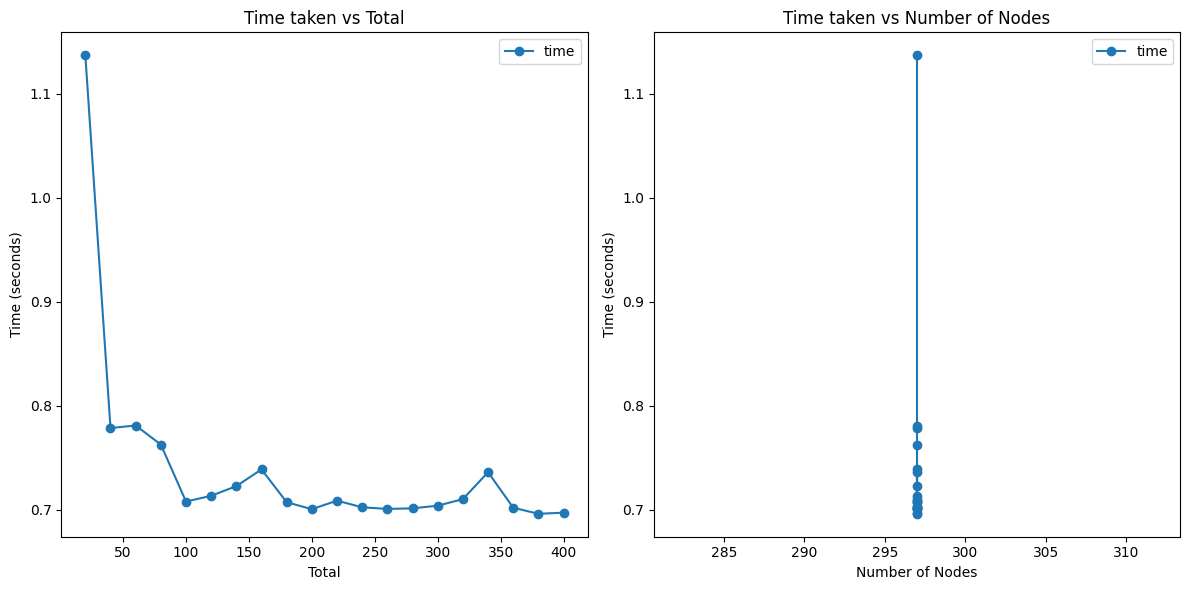

In [304]:
import pandas as pd
import matplotlib.pyplot as plt

time_df = pd.DataFrame(times)

# Assuming time_df is your DataFrame
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for subplots

# Plot on the first subplot
time_df.plot(ax=axs[0], x="total", y="time", title="Time taken vs Total", marker='o', linestyle='-')
axs[0].set_xlabel("Total")
axs[0].set_ylabel("Time (seconds)")

# Plot on the second subplot
time_df.plot(ax=axs[1], x="num_nodes", y="time", title="Time taken vs Number of Nodes", marker='o', linestyle='-')
axs[1].set_xlabel("Number of Nodes")
axs[1].set_ylabel("Time (seconds)")

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()


In [369]:
workload = dataloader.generate_workload(k=1.1)

4000


In [135]:
import random
print(f"Workload length: {len(workload)}")
scheduler = LPScheduler(2, depth_limit=3, update_interval=5)
runtime_selected = []
for i in range(7):
    runtime = scheduler.runtime_selector(input_ids=workload[i]["input_ids"]["input_ids"], text=workload[i]["text"])
    if i % 5 == 0 and i!=0:
        scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)
print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


Workload length: 4000
Set parameter Username
current_gpu_selection set()
set()
current_gpu_selection set()
set()
current_gpu_selection set()
set()
current_gpu_selection set()
set()
current_gpu_selection set()
set()
Set parameter Username


TypeError: unhashable type: 'list'

In [99]:
pd.DataFrame(scheduler.metrics_dict )["mode"].unique()

array(['random'], dtype=object)

Index with max overhead: 5
Value with max overhead: 0.01766228675842285


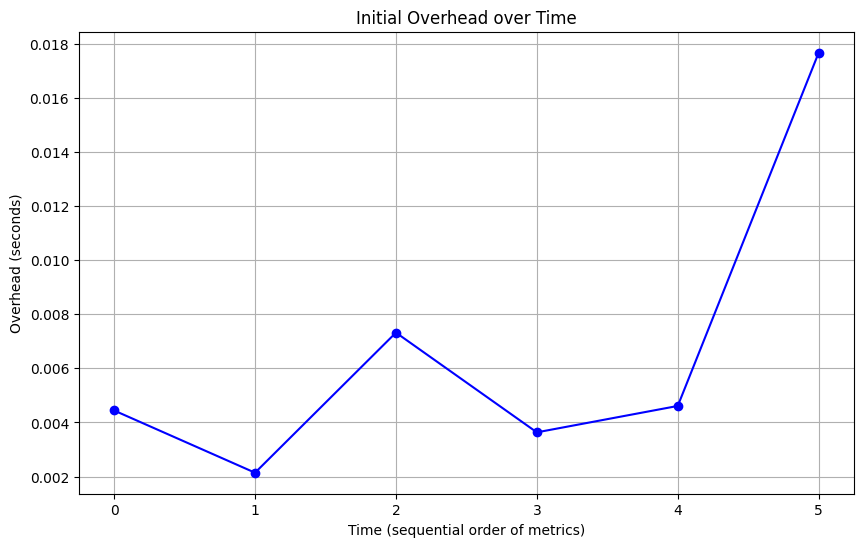

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [116]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load JSON data
file_name = 'metrics_lp_scheduler_2_200.json'
with open(file_name, 'r') as file:
    data = json.load(file)

# Extract overhead values
overhead_values = [entry['overhead'] for entry in data]
max_index = np.argmax(overhead_values)
max_value = overhead_values[max_index]
print("Index with max overhead:", max_index)
print("Value with max overhead:", max_value)

std_dev = np.std(overhead_values) / 4  # Reduced for visualization purposes
error = [std_dev] * len(overhead_values)
# Initial Plot
plt.figure(figsize=(10, 6))
plt.plot(overhead_values, marker='o', linestyle='-', color='b')
plt.title('Initial Overhead over Time')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('initial_overhead_plot.png')
# plt.close()
plt.show()
# More Smoothed Plot
more_smoothed_overhead = savgol_filter(overhead_values, 21, 3)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(overhead_values)), more_smoothed_overhead, yerr=error, marker='o', linestyle='-', color='g', ecolor='lightgray', elinewidth=3, capsize=0)
plt.title('More Smoothed Overhead over Time with Error Bars')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('more_smoothed_overhead_with_error_bars.png')
# plt.close()
plt.show()



# %%
# Initialize a dictionary to map the first 10 characters to the selected runtime
runtime_selection = {}
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if matched_tool:
        tool = matched_tool.group(1)
    first_10_chars = tool
    selected_runtime = entry['selected_runtime']
    # If the first 10 characters have been seen before
    if first_10_chars in runtime_selection:
        # Check if the selected runtime matches the previously recorded runtime
        if runtime_selection[first_10_chars] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {first_10_chars}")
    else:
        # Record the runtime selection for the first 10 characters
        runtime_selection[first_10_chars] = selected_runtime
        # Assuming the first selection is always correct as there's no precedent
        correct_predictions += 1

# Calculate the accuracy
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

In [71]:
runtime_selection = {}
first_occurrences = set()  # Keep track of tools that have been seen once
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if not matched_tool:
        ignore_items += 1
        continue  # If no tool is matched, skip this entry
    
    tool = matched_tool.group(1)[:10]  # Extract first 10 chars of the tool name
    selected_runtime = entry['selected_runtime']
    
    # Check if it's the first occurrence of the tool
    if tool not in first_occurrences and tool not in runtime_selection:
        first_occurrences.add(tool)  # Mark it as seen for the first time
        ignore_items += 1
        continue  # Move to the next entry without doing anything else
    
    # If it's the second time we see the tool, record its runtime
    if tool in first_occurrences and tool not in runtime_selection:
        runtime_selection[tool] = selected_runtime
        ignore_items += 1
        continue  # Move to the next entry after recording the second runtime
    
    # From the third occurrence onwards, we check predictions
    if tool in runtime_selection:
        if runtime_selection[tool] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {tool}")

print(f"Correct predictions (excluding first occurrences): {correct_predictions}")
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

Incorrect prediction for tool: ipl_api
Incorrect prediction for tool: nba_statis
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: dota2_hero
Incorrect prediction for tool: fear_and_g
Incorrect prediction for tool: calltracki
Incorrect prediction for tool: get_10000_
Incorrect prediction for tool: manga_scra
Incorrect prediction for tool: dota_2_ste
Incorrect prediction for tool: store_apps
Incorrect prediction for tool: cigars
Incorrect prediction for tool: seeking_al
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: musiclinks
Incorrect prediction for tool: dota_2_ste
Incorrect prediction for tool: instagram_
Incorrect prediction for tool: manga_scra
Incorrect prediction for tool: hryvna_tod
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: cigars
Incorrect prediction for tool: proxypage
Incorrect prediction for tool: cigars
Incorrect prediction for tool: world_coun
Incorrect prediction for tool: famous_quo
Incorrec

49.01315789473684